[512 863]
The two most likely earthquake locations are:
[512 863]
x1, y1 =  0.2743433190292394 0.4322958978570361
x2, y2 =  -0.842216165553134 0.18825761732523844
Probability of earthquake 1:  0.26664919607887755
Probability of earthquake 2:  0.4999987791791067


<Figure size 1000x800 with 0 Axes>

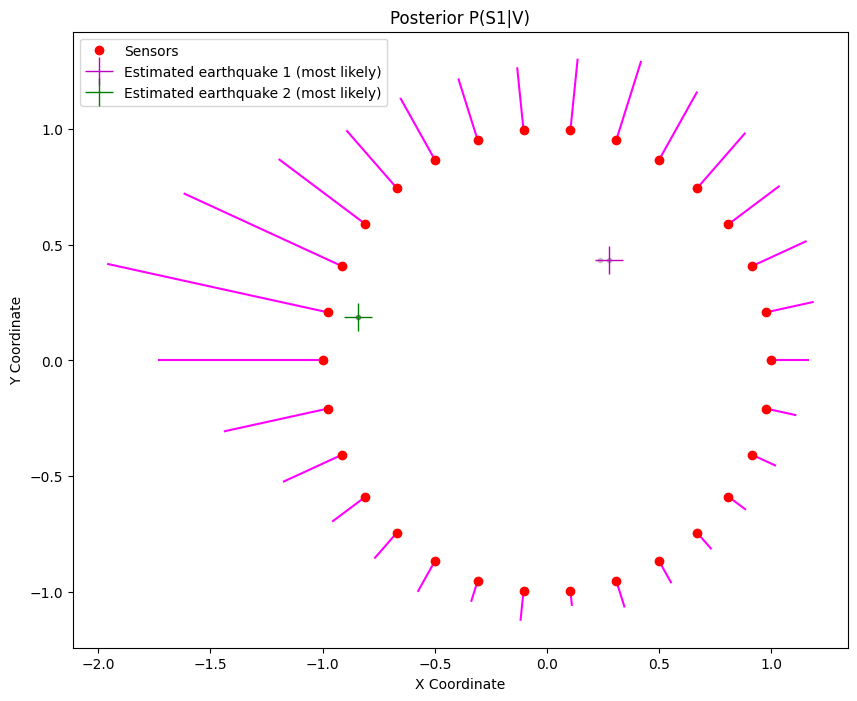

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def value(x_true, y_true, x_sensor, y_sensor):
    # defines the likelihood of a sensor reading based on the true location of an earthquake
    return 1 / (0.1 + (x_true - x_sensor)**2 + (y_true - y_sensor)**2)

def earthquake(v_observed, n):
    # Define the coordinate system:
    S = 1000  # number of points on the spiral
    theta = 55 * 2 * np.pi * np.arange(S) / S
    r = np.arange(S) / S
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Define the locations of the detection stations on the surface
    N = len(v_observed)  # number of stations (will be overwritten by file length)
    theta_sensor = 2 * np.pi * np.arange(N) / N
    x_sensor = np.cos(theta_sensor)
    y_sensor = np.sin(theta_sensor)

    # Calculate the explosion values for the sensors = estimated values: 1 EARTHQUAKE
    v = np.zeros((S, N))
    for sensor in range(N):
        for s in range(S):
            v[s, sensor] = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor])

    # Calculate the explosion values for the sensors = estimated values: 2 EARTHQUAKES
    v = np.zeros((S, S, N))
    for sensor in range(N):
        for s in range(S):
            for s1 in range(S):
                v[s, s1, sensor] = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor]) + value(x[s1], y[s1], x_sensor[sensor], y_sensor[sensor])
    
    # Perform inference p(location|observed sensor values) given these sensor values
    # P(V | S1)            
    likelihood = np.ones((S,S)) 
    for sensor in range(N):
        #how likely is it a certain sensor to observe that value in a normal distr with the specified mean and standard deviation
        #effectively re-weighting the data to reflect its likelihood or importance according to a predefined statistical model
        likelihood[:, :] *= norm.pdf(v[:,:,sensor], v_observed[sensor], 0.2) 
    summation_s2 = np.sum(likelihood,axis = 0) #marginalise out earthquake 2: geeft P(v|s1)

    # P(s1 | V)
    posterior = summation_s2   / np.sum(summation_s2 ) #divide by P(V)

    # Find the indices of the two most likely earthquake locations
    max_idx = np.argsort(posterior)[-2:]
    print(max_idx)
    
    print("The two most likely earthquake locations are:")
    print(max_idx)
    print("x1, y1 = ", x[max_idx[0]], y[max_idx[0]])
    print("x2, y2 = ", x[max_idx[1]], y[max_idx[1]])
    print("Probability of earthquake 1: ", posterior[max_idx[0]])
    print("Probability of earthquake 2: ", posterior[max_idx[1]])

    #PLOTTING
    cmap = plt.cm.gray_r 
    plt.figure(figsize=(10, 8))
    plt.figure(figsize=(10, 8))
    for i in range(S):
        color = cmap(posterior[i])  # Map the normalized probability to a color
        plt.plot(x[i], y[i], ".", color=color)

    for sensor in range(N):
    # Normalize the line length to the observed data
        line_length = v_observed[sensor] / np.max(v_observed)
        plt.plot([x_sensor[sensor], x_sensor[sensor] * (1 + line_length)],
                [y_sensor[sensor], y_sensor[sensor] * (1 + line_length)],
                color='magenta')

    
    plt.plot(x_sensor, y_sensor, "ro", label="Sensors")
    plt.plot(x[max_idx[0]], y[max_idx[0]], "m+", markersize=20, label="Estimated earthquake 1 (most likely)")
    plt.plot(x[max_idx[1]], y[max_idx[1]], "g+", markersize=20, label="Estimated earthquake 2 (most likely)")
    plt.legend()
    plt.title('Posterior P(S1|V)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

    return max_idx

# Read observed values from file
with open("EarthquakeExerciseData.txt") as f:
    lines = f.readlines()
v_observed = [float(line.strip()) for line in lines]
num_explosions = 2

max_idx = earthquake(v_observed, num_explosions)

